# Pathway interpolation

Before starting with the NEB calculations, we need to prepare the most important input file for NEB, which is the initial pathway.

The initial pathway is very important in NEB. A good pathway will give you a good initial guess of the minimum energy pathway (MEP). A bad pathway will give you a bad initial guess of the MEP. In the latter case, the NEB method will not converge to the MEP. A good pathway can also reduce the number of iterations needed to converge to the MEP leading to a faster calculation.

There are two ways to generate a pathway:

1. Linear interpolation - A straight line between the initial and final states. 
2. `idpp` interpolation - A more sophisticated interpolation method.

In this notebook, we will generate the initial pathway using Linear and `idpp` interpolation methods and compare the results using different systems. 

In [1]:
from ase.visualize.plot import plot_atoms
import matplotlib.pyplot as plt
from ase.neb import NEB, NEBTools
from copy import deepcopy
from ase.calculators.emt import EMT
from ase.constraints import FixAtoms
from ase.optimize import LBFGS
from ase.build import add_adsorbate, fcc100, molecule, fcc111
from ase.lattice.cubic import FaceCenteredCubic
from ase import Atoms
import numpy as np
from ase.io import read, write

def show_is_fs(is_in,fs_in):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    plot_atoms(is_in, ax[0], radii=0.8)
    plot_atoms(fs_in, ax[1], radii=0.8)
    ax[0].axis('off')
    ax[1].axis('off')
    ax[0].set_title('Initial state')
    ax[1].set_title('Final state')
    plt.show();

def make_images(is_in, fs_in, constraints=None):    
    nimages = 7
    images = [is_in]
    for i in range(nimages-2):
        img = is_in.copy()
        img.calc = EMT()
        if constraints is not None:
            img.set_constraint(constraints)
        images.append(img)
    images.append(fs_in)
    
    images_linear = deepcopy(images)   
    neb = NEB(images_linear) 
    neb.interpolate()
    
    images_idpp = deepcopy(images)
    neb = NEB(images_idpp)
    neb.interpolate(method='idpp')
    
    return images_linear, images_idpp

def get_barrier(images):
    energies = np.array([image.get_potential_energy() for image in images])
    barrier = energies.max() - energies[0] 
    return barrier

def check_counter(fname):
    x = read(fname, ":")
    lenx = len(x)
    return lenx / 7
    


## Cases

### Au adsorbed on Al(001) surface

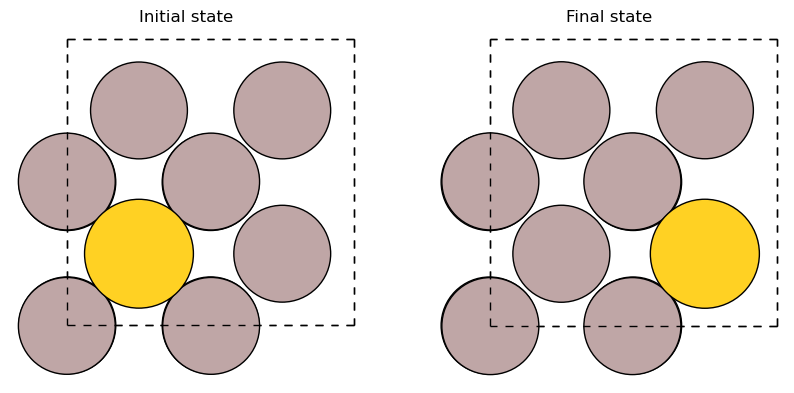

In [2]:
# 2x2-Al(001) surface with 3 layers and an
# Au atom adsorbed in a hollow site:
slab = fcc100('Al', size=(2, 2, 3))
add_adsorbate(slab, 'Au', 1.7, 'hollow')
slab.center(axis=2, vacuum=4.0)

# Fix second and third layers:
constraint = FixAtoms(mask=[atom.tag > 1 for atom in slab])
slab.set_constraint(constraint)

# Use EMT potential:
slab.calc = EMT()

# Initial state:
qn = LBFGS(slab, logfile=None)
qn.run(fmax=0.05);
au_al_initial = deepcopy(slab)

# Final state:
slab[-1].x += slab.get_cell()[0, 0] / 2
qn = LBFGS(slab, logfile=None)
qn.run(fmax=0.05);
au_al_final = deepcopy(slab)

# Make images
au_al_images_linear, au_al_images_idpp = make_images(au_al_initial, au_al_final, constraint)

show_is_fs(au_al_initial, au_al_final)




In [3]:
neb_linear = NEB(au_al_images_linear)
qn = LBFGS(neb_linear, trajectory="tmp_counter.traj", logfile=None)
qn.run(fmax=0.05)
barrier = get_barrier(au_al_images_linear)
print('Linear interpolation barrier:', barrier)
count = check_counter('tmp_counter.traj')
print('Number of iterations:', count)


neb_idpp = NEB(au_al_images_idpp)
qn = LBFGS(neb_idpp, trajectory="tmp_counter.traj", logfile=None)
qn.run(fmax=0.05)
barrier = get_barrier(au_al_images_idpp)
print('IDPP interpolation barrier:', barrier)
count = check_counter('tmp_counter.traj')
print('Number of iterations:', count)

Linear interpolation barrier: 0.37400613132093774
Number of iterations: 18.0
IDPP interpolation barrier: 0.37400613132093774
Number of iterations: 18.0


### Ethane

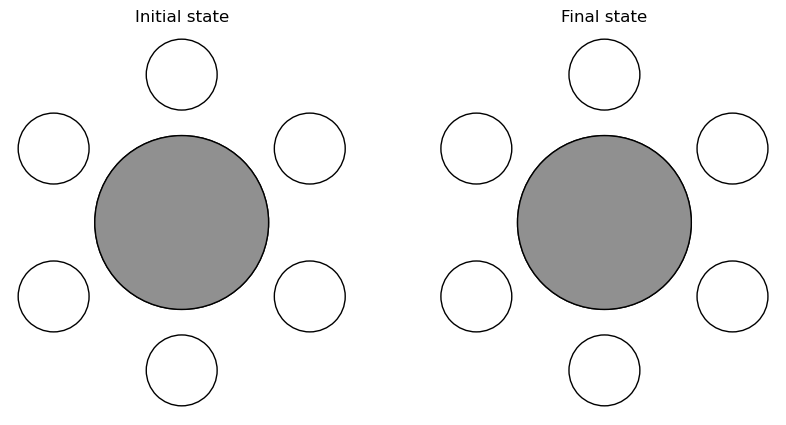

In [4]:
# Optimise molecule.
initial = molecule('C2H6')
initial.calc = EMT()
relax = LBFGS(initial, logfile=None)
relax.run(fmax=0.05)

# Create final state.
final = initial.copy()
final.positions[2:5] = initial.positions[[3, 4, 2]]
final.calc = EMT()
final.get_potential_energy()


c2h6_images_linear, c2h6_images_idpp = make_images(initial, final)

show_is_fs(initial, final)

In [5]:
neb_linear = NEB(c2h6_images_linear)
qn = LBFGS(neb_linear, trajectory="tmp_counter.traj", logfile=None)
qn.run(fmax=0.05)
barrier = get_barrier(c2h6_images_linear)
print('Linear interpolation barrier:', barrier)
count = check_counter('tmp_counter.traj')
print('Number of iterations:', count)


neb_idpp = NEB(c2h6_images_idpp)
qn = LBFGS(neb_idpp, trajectory="tmp_counter.traj", logfile=None)
qn.run(fmax=0.05)
barrier = get_barrier(c2h6_images_idpp)
print(f'IDPP interpolation barrier: {barrier:.4f}', )
count = check_counter('tmp_counter.traj')
print('Number of iterations:', count)

Linear interpolation barrier: 0.0
Number of iterations: 18.0
IDPP interpolation barrier: 0.0000
Number of iterations: 4.0


### N diffusion over a step edge

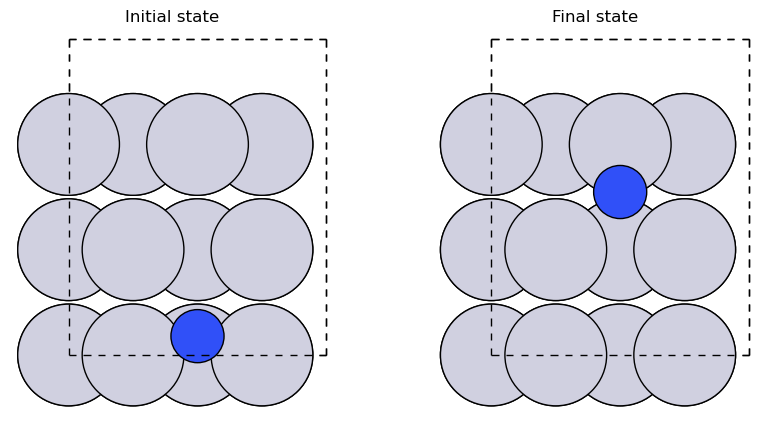

In [6]:
# Set the number of images you want.
nimages = 7

# Some algebra to determine surface normal and the plane of the surface.
d3 = [2, 1, 1]
a1 = np.array([0, 1, 1])
d1 = np.cross(a1, d3)
a2 = np.array([0, -1, 1])
d2 = np.cross(a2, d3)

# Create the slab.
slab = FaceCenteredCubic(directions=[d1, d2, d3],
                         size=(2, 1, 2),
                         symbol=('Pt'),
                         latticeconstant=3.9)

# Add some vacuum to the slab.
uc = slab.get_cell()
uc[2] += [0., 0., 10.]  # There are ten layers of vacuum.
uc = slab.set_cell(uc, scale_atoms=False)

# Some positions needed to place the atom in the correct place.
x1 = 1.379
x2 = 4.137
x3 = 2.759
y1 = 0.0
y2 = 2.238
z1 = 7.165
z2 = 6.439


# Add the adatom to the list of atoms and set constraints of surface atoms.
slab += Atoms('N', [((x2 + x1) / 2, y1, z1 + 1.5)])
mask = [atom.symbol == 'Pt' for atom in slab]
constraint = FixAtoms(mask=mask)    
slab.set_constraint(constraint)


# Optimise the initial state: atom below step.
initial = slab.copy()
initial.calc = EMT()
relax = LBFGS(initial, logfile=None)
relax.run(fmax=0.05)

# Optimise the final state: atom above step.
slab[-1].position = (x3, y2 + 1., z2 + 3.5)
final = slab.copy()
final.calc = EMT()
relax = LBFGS(final, logfile=None)
relax.run(fmax=0.05)

nstepedge_images_linear, nstepedge_images_idpp = make_images(initial, final, constraint)

show_is_fs(initial, final)


In [7]:
neb_linear = NEB(nstepedge_images_linear)
qn = LBFGS(neb_linear, trajectory="tmp_counter.traj", logfile=None)
qn.run(fmax=0.05)
barrier = get_barrier(nstepedge_images_linear)
print('Linear interpolation barrier:', barrier)
count = check_counter('tmp_counter.traj')
print('Number of iterations:', count)


neb_idpp = NEB(nstepedge_images_idpp)
qn = LBFGS(neb_idpp, trajectory="tmp_counter.traj", logfile=None)
qn.run(fmax=0.05)
barrier = get_barrier(nstepedge_images_idpp)
print(f'IDPP interpolation barrier: {barrier:.4f}', )
count = check_counter('tmp_counter.traj')
print('Number of iterations:', count)

Linear interpolation barrier: 0.16275609990678586
Number of iterations: 10.0
IDPP interpolation barrier: 0.1633
Number of iterations: 7.0


### N2 dissociation on Cu(111) surface

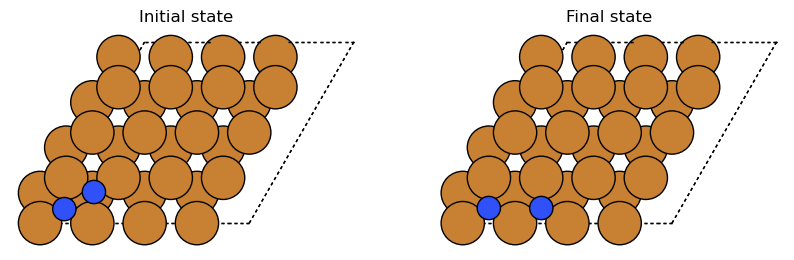

In [8]:
# Set up a (4 x 4) two layer slab of Cu:
slab = fcc111('Cu', size=(4, 4, 2))
slab.set_pbc((1, 1, 0))

# Set up a (4 x 4) two layer slab of Cu:
slab = fcc111('Cu', size=(4, 4, 2))
slab.set_pbc((1, 1, 0))

# We don't want to worry about the Cu degrees of freedom,
# so fix these atoms:
constraint = FixAtoms(mask=[atom.symbol == 'Cu' for atom in slab])
slab.set_constraint(constraint)

# Initial state.
# Add the N2 molecule oriented at 60 degrees:
d = 1.10  # N2 bond length
N2mol = Atoms('N2', positions=[[0.0, 0.0, 0.0],
                               [0.5 * 3**0.5 * d, 0.5 * d, 0.0]])
add_adsorbate(slab, N2mol, height=1.0, position='fcc')

# Relax the structure
initial = slab.copy()
initial.calc = EMT()
relax = LBFGS(initial, logfile=None)
relax.run(fmax=0.05)

# Now the final state.
# Move the second N atom to a neighboring hollow site:
slab[-1].position[0] = slab[-2].position[0] + 0.25 * slab.cell[0, 0]
slab[-1].position[1] = slab[-2].position[1]
final = slab.copy()
final.calc = EMT()
relax = LBFGS(final, logfile=None)
relax.run(fmax=0.05)

ndissoc_images_linear, ndissoc_images_idpp = make_images(initial, final, constraint)

show_is_fs(initial, final)




In [9]:
neb_linear = NEB(ndissoc_images_linear)
qn = LBFGS(neb_linear, trajectory="tmp_counter.traj", logfile=None)
qn.run(fmax=0.05)
barrier = get_barrier(ndissoc_images_linear)
print('Linear interpolation barrier:', barrier)
count = check_counter('tmp_counter.traj')
print('Number of iterations:', count)


neb_idpp = NEB(ndissoc_images_idpp)
qn = LBFGS(neb_idpp, trajectory="tmp_counter.traj", logfile=None)
qn.run(fmax=0.05)
barrier = get_barrier(ndissoc_images_idpp)
print(f'IDPP interpolation barrier: {barrier:.4f}', )
count = check_counter('tmp_counter.traj')
print('Number of iterations:', count)

Linear interpolation barrier: 0.02048484536599382
Number of iterations: 3.0
IDPP interpolation barrier: 0.0205
Number of iterations: 3.0


## Summary

From the results there is a pattern that can be observed. In general, the `idpp` interpolation method gives a better initial pathway than the linear interpolation method. At the worst case, the `idpp` interpolation method gives the same results as the linear interpolation method. In the best case, the `idpp` interpolation method gives a better initial pathway than the linear interpolation method by allowing a lower number of iterations used. 

TLDR: Use `idpp` interpolation method to generate the initial pathway for NEB calculations.